In [1]:
import coffea
from coffea.nanoevents.methods import vector
import coffea.hist as hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import sys,os

# from pyjet import cluster
import awkward as ak

from sklearn.cluster import DBSCAN

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema,BaseSchema

sys.path.append(os.getcwd().replace('scripts', 'lib'))
import util

# from numba import jit

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._floa

# Open data files

 * First file contains collision data taken with large MET in the trigger in 2016. This is a sub-set of the analysis nTuple that you will use in the rest of the exercise.
 * The 2nd file contains signal simulation with $H\rightarrow SS \rightarrow 4b$ events

In [2]:
fpath = "/eos/uscms/store/user/cmsdas/2025/long_exercises/MDS/data/displacedJetMuon_ntupler.root"
data = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()

fpath ="/eos/uscms/store/user/cmsdas/2025/long_exercises/MDS/signal/displacedJetMuon_ntupler.root"

signal = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="ntuples/llp"
                                  ).events()

## The tree is loaded with the "coffea" analysis framework
The events are loaded into an "awkward arrays", i.e. arrays with irregular sizes
Our event-based data fits into awkward arrays very naturally!
 - Tree:
 -  |-muonPt :[ [Pt1,Pt2], [Pt1] ...]
 -  |-muonEta:[ [Eta1,Eta2], [Eta1] ...]

In [3]:
# this awkward array has 16965 events, of the type "event"
data

<NanoEventsArray [{isData: True, nPV: 12, ... -666]}] type='16965 * event'>

In [4]:
# shows the branches of the tree
data.fields

['isData',
 'nPV',
 'runNum',
 'nSlimmedSecondV',
 'lumiNum',
 'eventNum',
 'eventTime',
 'pvX',
 'pvY',
 'pvZ',
 'fixedGridRhoAll',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetAllCalo',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'fixedGridRhoFastjetCentralNeutral',
 'nPVAll',
 'pvAllX',
 'pvAllY',
 'pvAllZ',
 'pvAllLogSumPtSq',
 'pvAllSumPx',
 'pvAllSumPy',
 'nBunchXing',
 'BunchXing',
 'nPU',
 'nPUmean',
 'nMuons',
 'muonE',
 'muonPt',
 'muonEta',
 'muonPhi',
 'muonCharge',
 'muonIsLoose',
 'muonIsMedium',
 'muonIsTight',
 'muon_d0',
 'muon_dZ',
 'muon_ip3d',
 'muon_ip3dSignificance',
 'muonType',
 'muonQuality',
 'muon_pileupIso',
 'muon_chargedIso',
 'muon_photonIso',
 'muon_neutralHadIso',
 'muon_ptrel',
 'muon_chargedMiniIso',
 'muon_photonAndNeutralHadronMiniIso',
 'muon_chargedPileupMiniIso',
 'muon_activityMiniIsoAnnulus',
 'muon_passSingleMuTagFilter',
 'muon_passHLTFilter',
 'muon_validFractionTrackerHits',
 'muon_isGlobal',
 'muon_no

## Accessing a branch like this will give the data in the format of (awkward)arrays
 - Note that the type becomes "int32"
 - For event-level quantity (number of total rechits),
   the length of array is the **same** as the number of events

In [5]:
data.ncscRechits

<Array [41, 56, 25, 10, 64, ... 8, 48, 52, 52] type='16965 * int32[parameters={"...'>

 - For object-level quantity (X pos. of each rechit), the first dimension of array is the same as the number of events, but the 2nd dimension of the array is **variable (var, float32)** 

In [6]:
data.cscRechitsX

<Array [[116, 116, 116, ... -117, -133, -117]] type='16965 * var * float32[param...'>

## Pack all the rechit properties arrays in 1 object

In [7]:
def pack(events,obj_str):
    obj  = ak.zip(
                {k.replace(obj_str,""):getattr(events,k) for k in events.fields if k.startswith(obj_str)}
                ,with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior
               )
    return obj

In [8]:
rechits = pack(data,"cscRechits")

In [9]:
d_rechits = rechits
s_rechits = pack(signal,"cscRechits")

 - These properties mostly follow from the CMSSW definition: [here](https://github.com/cms-sw/cmssw/blob/master/DataFormats/CSCRecHit/interface/CSCRecHit2D.h)
 - Our nTuplizer only dropped a few properties and computed a few new ones
 - We will use the following properties:
   - Eta,Phi
   - X,Y,Z
   - Tpeak (Time calculated from strip input), Twire (Time calculated from wire input) [src code](https://github.com/cms-sw/cmssw/blob/master/RecoLocalMuon/CSCRecHitD/src/CSCMake2DRecHit.cc)
   - Station

In [10]:
rechits.fields

['Phi',
 'Eta',
 'X',
 'Y',
 'Z',
 'E',
 'Tpeak',
 'Twire',
 'Quality',
 'Chamber',
 'Station',
 'ClusterId',
 'Channels',
 'NStrips',
 'HitWire',
 'WGroupsBX',
 'NWireGroups',
 'DetId']

In [11]:
# Check number of rechits per event
ak.num(rechits)

<Array [41, 56, 25, 10, 64, ... 8, 48, 52, 52] type='16965 * int64'>

## Look at the 2D event display of rechits

In [12]:
def displayRZ(i_event,rechits=[],cls=[]):
    
    #Select the rechits in the i-th event
    i_rh = rechits[i_event] if len(rechits)>0 else None
    i_cls = cls[i_event] if len(cls)>0 else None
    
    #Make a figure with 2 subplots
    fig, axs = plt.subplots(1,2, figsize=(18,8))

    axs = axs.flatten()
    #plot clusters:
    if len(cls)>0:
        #Eta-phi plot:        
        s1=axs[0].scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Nhit,label="Cluster")
        for cl in i_cls:
            cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
            axs[0].add_patch(cone)        
        
        #R-Z plot:        
        cls_r = (i_cls.X**2+i_cls.Y**2)**0.5        
        axs[1].scatter(np.abs(i_cls.Z),cls_r,s=i_cls.Nhit)            
    
    #plot rechits:
    if len(rechits)>0:
        #Eta-phi plot:
        s2=axs[0].scatter(i_rh.Eta,i_rh.Phi,s=1,label="Rechits")
        rh_r = (i_rh.X**2+i_rh.Y**2)**0.5    
        
        #R-Z plot:        
        axs[1].scatter(np.abs(i_rh.Z),rh_r,s=1)

    #label eta-phi plot
    axs[0].text(0.1,0.9,"%s-th event"%i_event,transform=axs[0].transAxes)
    axs[0].set_ylim(-np.pi,np.pi)
    axs[0].set_xlim(-5,5)
    axs[0].set_ylabel(r"$\phi$")
    axs[0].set_xlabel(r"$\eta$")
    
    #label RZ plot
    MB_xmin = 300
    util.drawRZ(axs[1],MB_xmin)
    axs[1].set_xlim(MB_xmin,None)
    axs[1].set_xlabel("|z|[cm]")
    axs[1].set_ylabel("R[cm]")
    
    #make legend
    handles, labels = [(a + b) for a, b in zip(axs[0].get_legend_handles_labels(), 
                                           axs[1].get_legend_handles_labels())]
    leg=fig.legend(handles, labels,
                   bbox_to_anchor=(1.0, 1.0), loc='upper left')   
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    plt.tight_layout()
    return

### Try to look at the rechits from different events!
Hint: find an event that has a large number of rechits first to get an interesting event!

In [13]:
# check which events have large number of rechits
np.where(ak.num(rechits)>400)

(<Array [162, 501, 2194, ... 15396, 16922] type='38 * int64'>,)

/tmp/ipykernel_885996/804603489.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


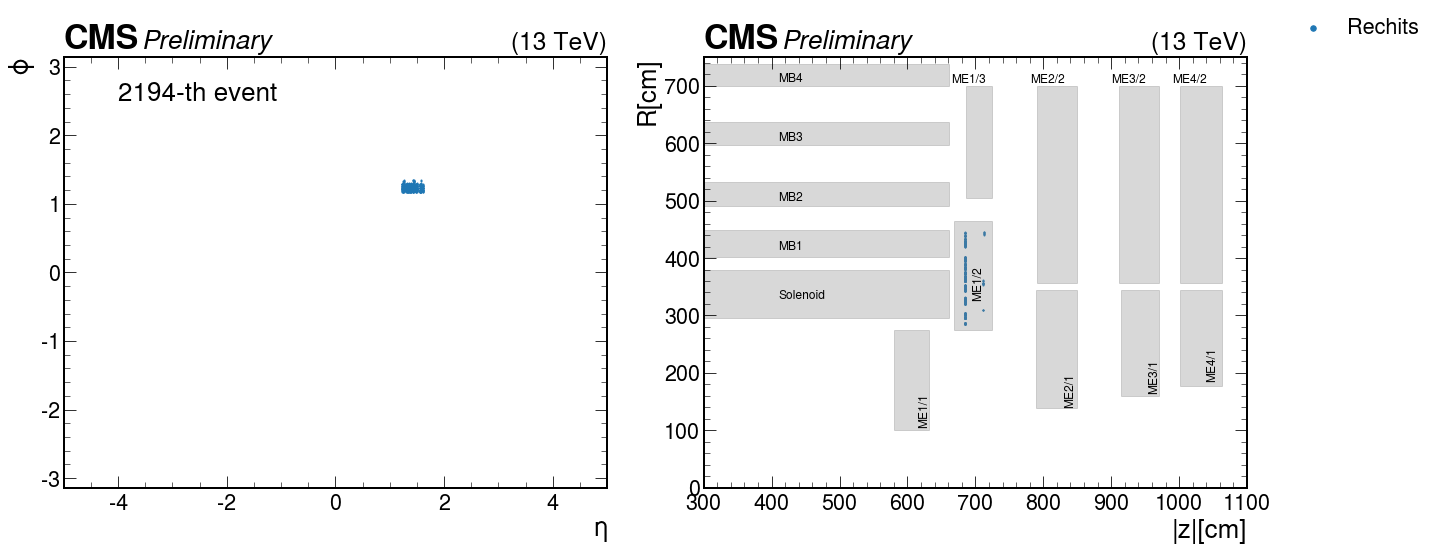

In [15]:
plt.style.use(hep.style.CMS) 
displayRZ(2194,rechits)

# Clustering the rechits

### First read the discussion in the lesson: [link](https://christinaw97.github.io/MDS_CMSDAS/03-MDS_reco/index.html#clustering-algorithm)

### Complete the function `computeCluster`, `computeStationProp` and `computeME11_12`

First read the definition of the cluster properties: [here](https://kakwok.github.io/MDS_CMSDAS/03-MDS_reco/index.html#cluster-properties)

Then try to implement them in the relevant functions.

In particular, 

### $\mathrm{avgStation10} = \frac{\sum_i (i \times nhits_i)}{\sum_i nhits_i}$

where `i` sums over the stations with at least 10 hits.

We are using DBSCAN algorithm, implemented with the python lib: `sklearn.cluster`

In [17]:
def DBScan(rechits,nCore,eps):
    points=ak.zip([rechits.Eta,rechits.Phi],highlevel=False)

    all_clusters = []
    for x,rechit in zip(points,rechits):
        n_clusters_=0
        core_samples_mask=[]
        ## format into DBSCAN input format x=[ [x1,y1],[x2,y2] ... ]        
        x=np.stack(ak.unzip(x),axis=1)
        i_clusters = []        
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            ## Loop over clusters in this event
            for iCs in range(n_clusters_):

                #Compute each cluster's properties:
                #    Input = rechits that belongs to this cluster (done via array masking)
                cls = computeCluster(rechit[labels==iCs])
                i_clusters.append(cls)
        all_clusters.append(i_clusters)
    return ak.Array(all_clusters)

# This function compute the cluster properties.
# The input `rechits` is an *array* of rechits used in the cluster  
# This function is ran for each event 
def computeCluster(rechits):
    cls = {}

    cls["Nhit"] = len(rechits)
    cls["Eta"] = np.mean(rechits.Eta)
    cls["Phi"] = np.mean(rechits.Phi)
    cls["X"] = np.mean(rechits.X)
    cls["Y"] = np.mean(rechits.Y)    
    cls["Z"] = np.mean(rechits.Z)        
    cls["Time"]= np.mean((rechits.Tpeak + rechits.Twire)/2)

    avgStation10,nStation10 = computeStationProp(rechits)
    nME11_12 = computeME11_12(rechits)
    
    cls["nStation10"] = nStation10
    cls['avgStation10'] = avgStation10
    cls["nME11_12"] = nME11_12
    
    return cls

# This function compute the cluster properties related to cluster stations.
# The input `rechits` is an *array* of rechits used in the cluster  
# This function is ran for each event 
def computeStationProp(rechits):
    # station can range from -4 to 4   
    uniqueStations = np.array([-4,-3,-2,-1,1,2,3,4])    
    nStation10   = 0
    avgStation10 = 0
    TotHitsStation10 = 0
    for i_station in uniqueStations:
        nRechit_in_i_station = sum(rechits.Station==i_station)
        if nRechit_in_i_station >=10:
            nStation10 +=1
            avgStation10 += i_station * nRechit_in_i_station
            TotHitsStation10 += nRechit_in_i_station
    avgStation10 = avgStation10/TotHitsStation10
    return avgStation10,nStation10

# This function compute the total number of rechits in ME11 and ME12 
# The input `rechits` is an *array* of rechits used in the cluster
# This function is ran for each event 
def computeME11_12(rechits):
    return ak.sum((abs(rechits.Chamber)==11)|(abs(rechits.Chamber)==12))

In [18]:
%%time

minPoint = 50
dR = 0.2
cls = DBScan(rechits,minPoint,dR)

CPU times: user 2min 1s, sys: 341 ms, total: 2min 1s
Wall time: 42.6 s


In [19]:
d_cls = cls
s_cls = DBScan(s_rechits,minPoint,dR)

In [21]:
cls.fields

['Nhit',
 'Eta',
 'Phi',
 'X',
 'Y',
 'Z',
 'Time',
 'nStation10',
 'avgStation10',
 'nME11_12']

## Try to see if the cluster in the previous event makes sense!
Hint: find an event that has a reconstructed cluster first

Do you see a cluster in the event that you chose?

In [20]:
# check which events have at least 1 cluster
np.where(ak.num(cls)>=1)

(<Array [5, 29, 42, 52, ... 16925, 16957, 16959] type='1515 * int64'>,)

/tmp/ipykernel_885996/804603489.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


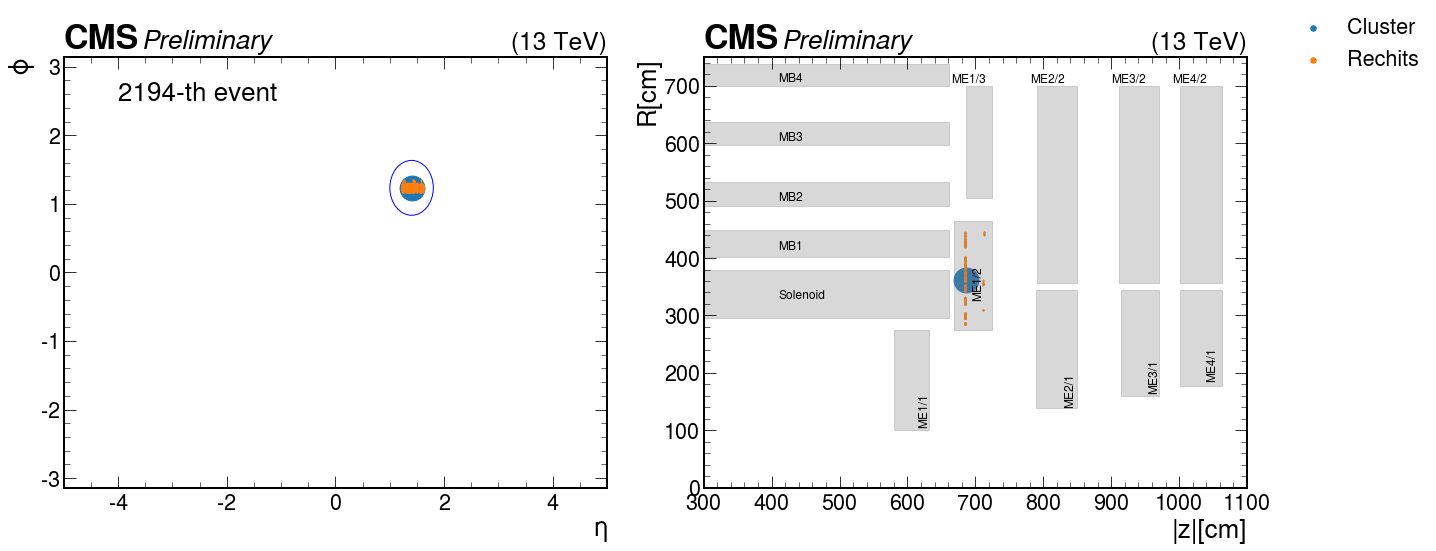

In [22]:
displayRZ(2194,rechits,cls)

# Examine cluster properties

In [23]:
samples=[
    {"cls":d_cls,"label":"data"}, 
    {"cls":s_cls,"label":"signal"},     
]
density=False

## Number of clusters and N_rechits

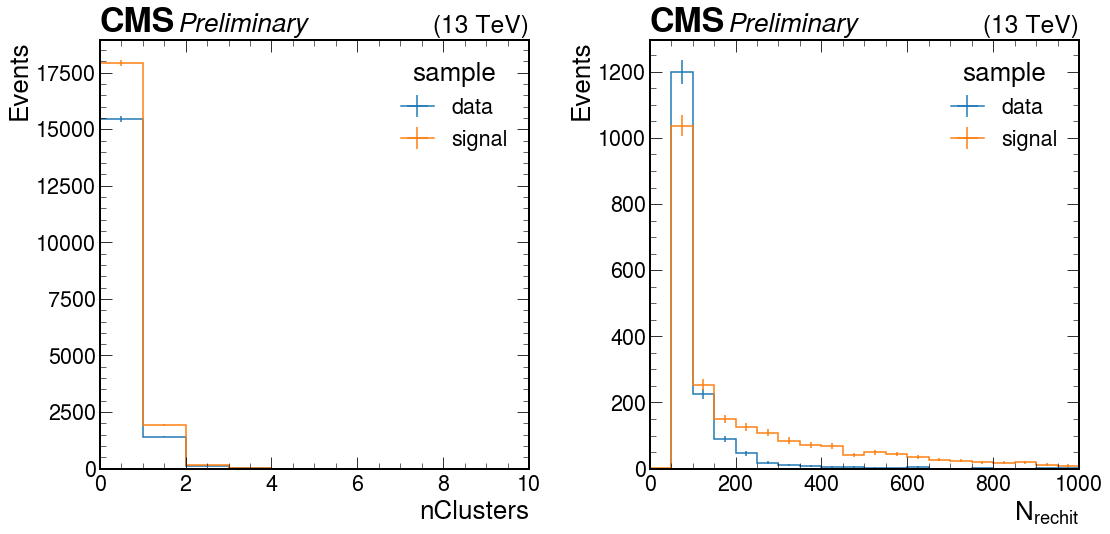

In [24]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nhit", r"$N_{rechit}$", 20, 0, 1000))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,nClusters=ak.num(cls))
    h2.fill(sample=label ,Nhit = ak.flatten(cls.Nhit))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Eta, Phi distributions

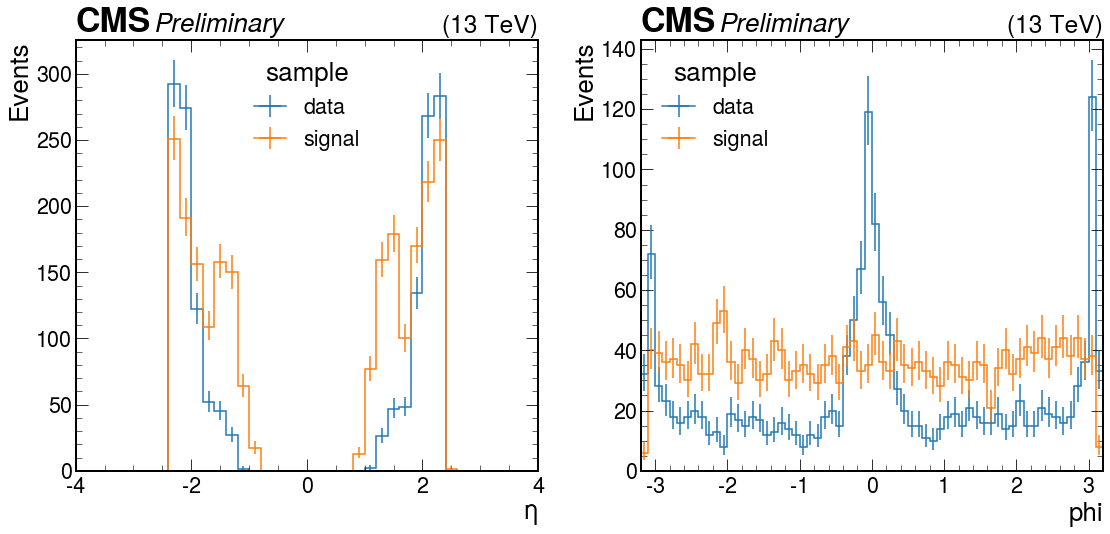

In [25]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", r"$\eta$", 40, -4, 4))
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 64, -3.2, 3.2))

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,eta = ak.flatten(cls.Eta))
    h2.fill(sample=label ,phi = ak.flatten(cls.Phi))

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# R, Z distributions

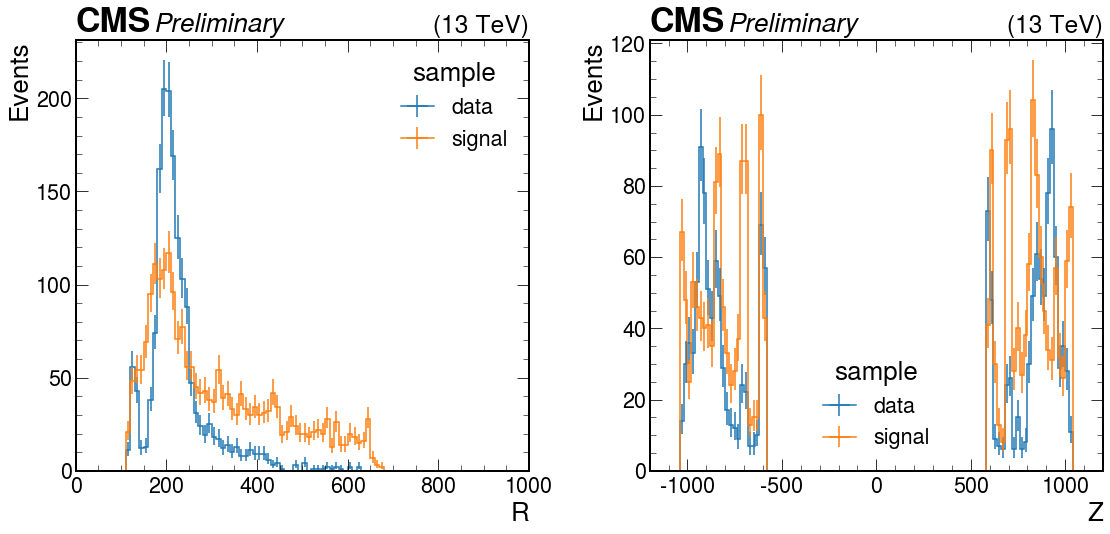

In [26]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs = axs.flatten()
h2 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("R", "R", 100, 0, 1000))        
h3 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Z", "Z", 120, -1200, 1200))            

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h2.fill(sample=label ,R = ak.flatten((cls.Y**2+cls.X**2)**0.5))
    h3.fill(sample=label ,Z = ak.flatten(cls.Z))        

hist.plot1d(h2,density=density,ax=axs[0])
hist.plot1d(h3,density=density,ax=axs[1])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Time, nStation10, AvgStation10 distributions

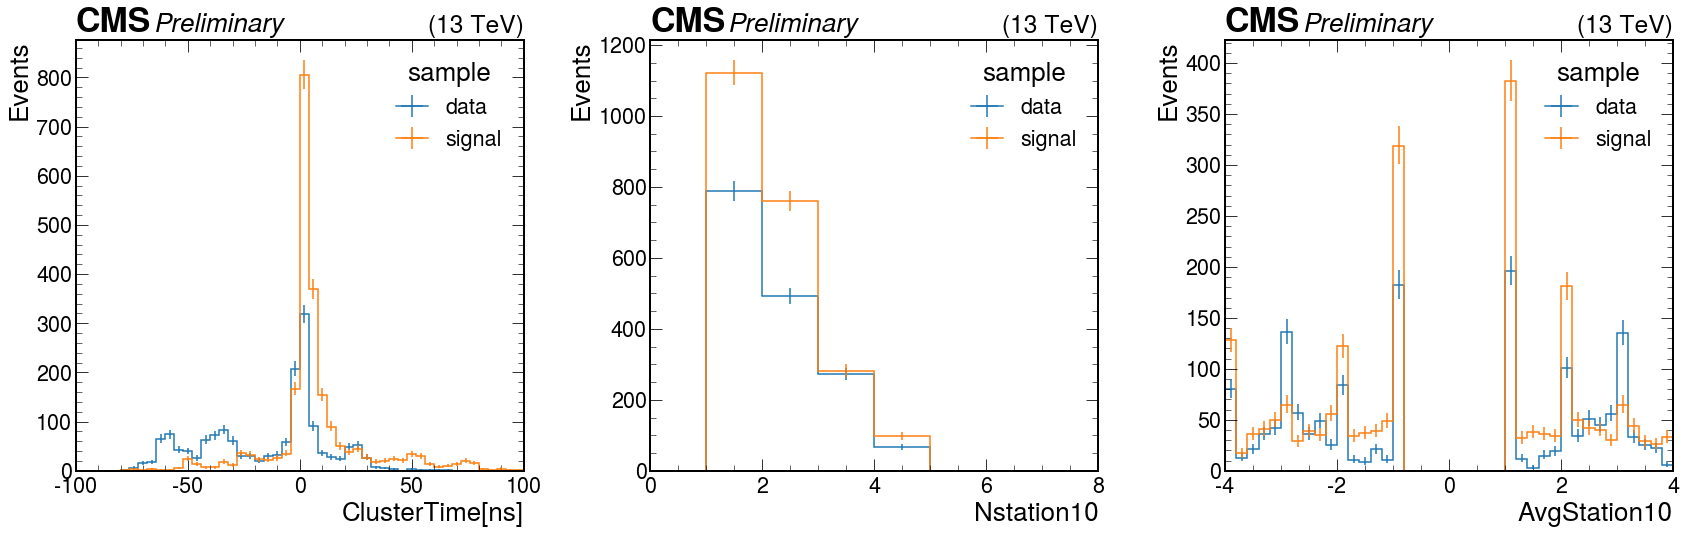

In [27]:
plt.style.use(hep.style.CMS)  
fig, axs = plt.subplots(1,3,figsize=(24,8))

axs = axs.flatten()
h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Time", 'ClusterTime[ns]',50, -100, 100))                        
h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nStation10", "Nstation10", 8, 0, 8))    
h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("avgStation10", "AvgStation10", 40, -4, 4))             

for sample in samples:
    cls = sample['cls']
    label = sample['label']
    h1.fill(sample=label ,Time = ak.flatten(cls.Time))
    h2.fill(sample=label ,nStation10 = ak.flatten(cls.nStation10))
    h3.fill(sample=label ,avgStation10 = ak.flatten(cls.avgStation10))    
    

hist.plot1d(h1,density=density,ax=axs[0])    
hist.plot1d(h2,density=density,ax=axs[1])
hist.plot1d(h3,density=density,ax=axs[2])
for ax in axs:
    
    hep.cms.label(ax=ax,data=True,label="Preliminary")        
    if density: ax.set_ylabel("Density")
plt.tight_layout()


# Bonus: Cluster ID

In the above plot, you should see there's no clear distinction between signal and data in `nStation10` and `Eta`, but some combination of nStation10 and eta may also help us to distinguish between signal and background.

We will use these variable to design a "ClusterID" later.

In [28]:
h= hist.Hist("Events",
              hist.Bin("nStation10", "Nstation10", 8, 0, 8),
              hist.Bin("eta", r"$\eta$", 40, -3, 3)
             )    
h.fill(nStation10=ak.flatten(cls.nStation10),
      eta = ak.flatten(cls.Eta))
h_group = h.group("nStation10",hist.Cat("nStationGrp","nStationGrp"),
                 {
                     "nStation=1":slice(0,2),
                     "nStation>=1":slice(2,None),                     
                 })

<Axes: xlabel='$\\eta$', ylabel='Events'>

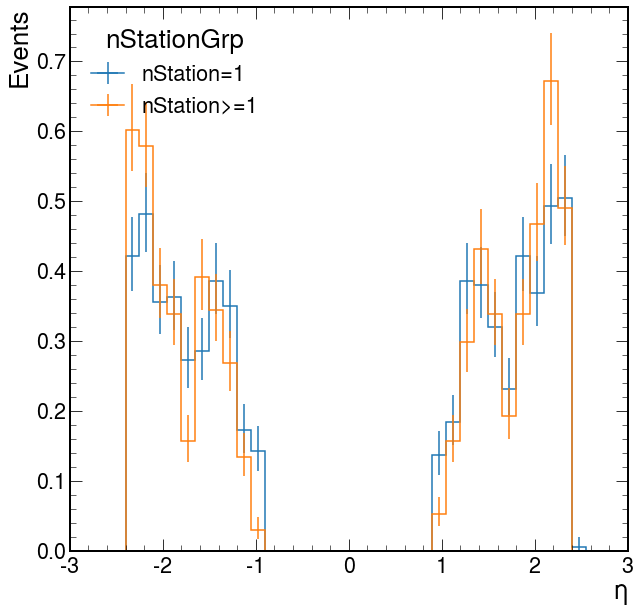

In [29]:
hist.plot1d(h_group,density=True)

In [ ]:
h.to_hist().project("eta","nStation10").plot2d_full()

# MDS reconstruction efficiency for signal

When an LLP decay in CSC, we want to know 
 - *how often* it can make an MDS cluster (this is cluster efficiency) and
 - where does the LLP decay when this happens
 
In this part, we will make a plot of MDS efficiency as a function LLP decay position and try to understand it. 

# load a signal ntuple

In this ntuple, the DBSCAN algorithm is already performed to reconstruct clusters from rechits, so only clusters and the cluster properties that you've seen in the previous exercise are stored

In [30]:
fpath ="/eos/uscms/store/user/cmsdas/2025/long_exercises/MDS/signal/nocuts/ggH_HToSSTobbbb_MH-125_MS-40_ctau-1000_137000pb_weighted.root"

signal = NanoEventsFactory.from_root(fpath,
                                   schemaclass=BaseSchema,
                                   treepath="MuonSystem"
                                  ).events()

In [31]:
signal

<NanoEventsArray [{runNum: 1, ... METTrigger: False}] type='6916000 * event'>

# Selections
Here we will select for events that have only one LLP decaying in the CSCs and calculate the probabilty of a cluster being reconstructed given that an LLP decayed in the CSC.
You will use the following branches:
* `gLLP_csc`: Boolean, a LLP-level variable that tells you whether an LLP decayed in CSC
* `gLLP_decay_vertex_z`: LLP-level variable that returns LLP lab frame decay vertex in Z [cm]
* `cscRechitCluster_match_gLLP_csc`: Boolean, cluster-level variable that returns true of the cluster is matched to an LLP ($\Delta R (cluster, LLP) < 0.4$) that decayed in CSC
* `cscRechitCluster_match_gLLP_decay_z`: float, cluster-level variable that returns the LLP decay vertex in z if its matched to an LLP

## Ex: Denominator selection

We will select events with only 1 LLP decaying in CSC.

There are 2 LLPs in each events. 

Compute the number of LLP that decays in the CSC first, then make a selection mask

How many events are there?

This will be the denominator of your signal efficiency.

In [47]:
nLLPinCSC = ak.sum(signal.gLLP_csc,axis=1)

In [48]:
# There are 2 conditions:
# - Only 1 LLP in CSC [This is an event level selection]
# - the LLP needs in CSC [This is an object level selection]
#  We need this condition because we will be applying this mask on obj. level array

denom_sel = (nLLPinCSC==1)&(signal.gLLP_csc==1)

In [49]:
print("Events with 1 LLP decaying in CSC: ", ak.sum(denom_sel))
print("Total generated signal events ", len(signal))
print("Acceptance in CSC ", ak.sum(denom_sel)/len(signal))

Events with 1 LLP decaying in CSC:  1075912
Total generated signal events  6916000
Acceptance in CSC  0.15556853672643145


In [50]:
# z coordinates of the LLP in the denominator
# we sum over the LLPs in the event axis(axis=1) [which there is only 1 LLP]
llp_z = ak.sum(abs(signal.gLLP_decay_vertex_z[denom_sel]),axis=1)

## Ex: Numerator selection 

Select events with only 1 cluster AND in the denominator.

Among those events, select the ones that there's one cluster matched to the LLP.

In [51]:
nClsInCSC = ak.sum(signal.cscRechitCluster_match_gLLP_csc,axis=1)

In [52]:
# There are 3 conditions:
# - Only 1 cluster in CSC [This is an event level selection]
# - Only 1 LLP in CSC     [This is an event level selection]
# - the cluster needs to be matched to the LLP [This is an object(cluster) level selection]
#  We need this condition because we will be applying this mask on obj. level array

numer_sel = (nClsInCSC==1) & (nLLPinCSC==1) & (signal.cscRechitCluster_match_gLLP_csc==1)

In [53]:
# z coordinates of the LLP in the numerator
# we sum over the clusters in the event axis(axis=1)[which there is only 1 cls]
cls_z = ak.sum(abs(signal.cscRechitCluster_match_gLLP_decay_z[numer_sel]),axis=1)

## EX: Inclusive efficiency

What is the overall efficiency of reconstructing an MDS cluster of 50 hits for this signal?

In [43]:
print("Events with 1 LLP decaying in CSC: ", ak.sum(denom_sel))
print("Events with 1 LLP decaying in CSC and a cluster matched to LLP: ", ak.sum(numer_sel))
print("Inclusive efficiency = %.2f"%(ak.sum(numer_sel)/ak.sum(denom_sel)))

Events with 1 LLP decaying in CSC:  1075912
Events with 1 LLP decaying in CSC and a cluster matched to LLP:  628077
Inclusive efficiency = 0.58


# Fill the histogram

This is an **example** of filling a histogram with a `category` axis (for different samples), 

and a `Bin` axis for storing the values. 

This is a compact way of handling the histograms. 

You will use this type of histograms later on in the exercise. 

Which varaible should we fill-in in the function?

In [54]:
#Create a 2D histogram with a "sample" axis and an axis
hz= hist.Hist("Events",
              hist.Cat("sample","sample"), 
              hist.Bin("z", "LLP decay Z[cm]", 35, 400, 1075)
             )

#Fill the LLP decay position in CSC in the denominator bin
hz.fill(sample="denom", z=llp_z)
#Fill the LLP decay position in CSC matched to a cluster in the numerator bin
hz.fill(sample="numer", z=cls_z)

# Efficiency v.s. decay position

We will plot the cluster reconstruction efficiency with repect to the LLP decay position and overlay the steel region in the plot.

Here's a function to draw the CSC steel region.

In [55]:
## A function to draw the CSC steel region
import matplotlib.patches as patches

def drawCSCz(ax):
    ax.set_xlim(350,1150)
    (xmin,xmax) = ax.get_xlim()

    xmin = 350
    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1075, 0),150, 2,color='grey',alpha=0.3)

    ax.text(570*1.045, y_max*1.02, 'ME1/1', fontsize=16,rotation=90,weight='bold')
    ax.text(670*1.02, y_max*1.02, 'ME1/2-3', fontsize=16,rotation=90,weight='bold')
    ax.text(800, y_max*1.02, 'ME2', fontsize=16,rotation=90,weight='bold')
    ax.text(920, y_max*1.02, 'ME3', fontsize=16,rotation=90,weight='bold')
    ax.text(1015, y_max*1.02,'ME4', fontsize=16,rotation=90,weight='bold')
    ax.text(xmin+15 ,y_max*0.5, "Steel", fontsize=26,rotation=90,weight='bold')
    ax.text(xmax-20,y_max*0.5, "Beyond CMS", fontsize=26,rotation=90,weight='bold')

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

## Plotting the efficiency 

We can obtain the 1D histogram by integrating the `numer`/`denom` bin in the 2D histogram.

e.g. `hz.integrate("sample",'numer')` will return a 1D histogram with only the numerator content.

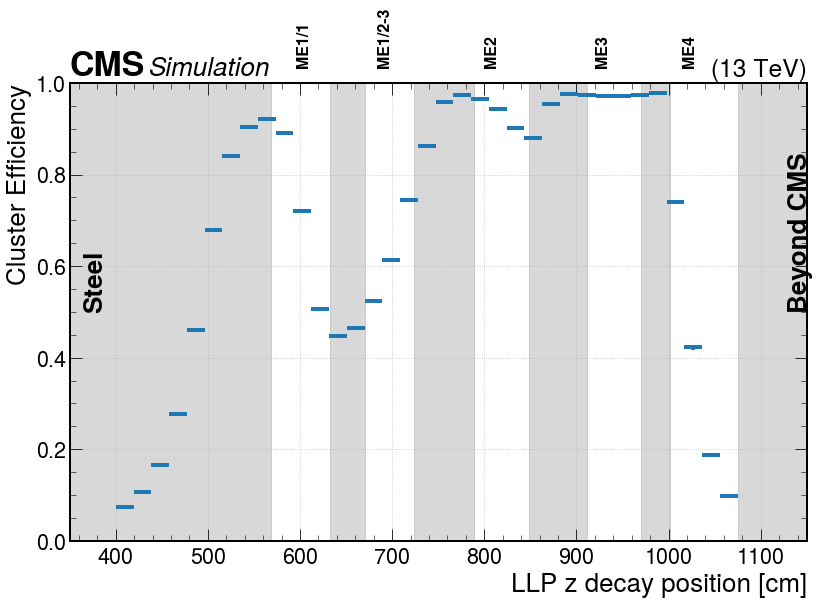

In [56]:
plt.style.use(hep.style.CMS)  
fig, ax = plt.subplots(1,1,figsize=(12,9))

# We use the "clopper-pearson" 
# Have a read of what it's doing here (the "efficiency" option): 
# https://hist.readthedocs.io/en/latest/reference/hist.intervals.html#hist.intervals.ratio_uncertainty

hist.plotratio(num=hz.integrate("sample",'numer'),
               denom=hz.integrate("sample",'denom'),xerr=True,
               error_opts={"linestyle":'none',"lw":4},ax=ax,
               unc = "clopper-pearson"
               )

ax.set_ylabel("Cluster Efficiency")
ax.set_xlabel("LLP z decay position [cm]")

ax=drawCSCz(ax)
ax.set_ylim(0,1)
ax.set_xlim(350,1150)
ax.grid() 
hep.cms.label(ax=ax,com=13)
plt.tight_layout()

# Ex: Plot the 2D histogram of LLP and cluster positions

- Why does the efficiency drops off at the two ends of the muon detectors?
- How does the efficiency varies between the muon stations? Do you understand why?
- Make a 2D histogram to confirm your understanding!

In [59]:
hz= hist.Hist("Events", 
              hist.Bin("z_llp", "LLP decay Z[cm]", 35, 400, 1075),
              hist.Bin("z_cls", "Cluster Z[cm]", 35, 400, 1075)              
             )
# Plot the LLP decay position in CSC
llp_z = ak.sum(abs(signal.gLLP_decay_vertex_z[denom_sel]),axis=1)

# Plot the position of the matched cluster in z
# - Get the cluster Z position
# - Apply the numerator selection you computed above
cls_z = ak.sum(abs(signal.cscRechitClusterZ[numer_sel]),axis=1)


hz.fill(z_llp=llp_z, z_cls = cls_z)

<Axes: xlabel='LLP decay Z[cm]', ylabel='Cluster Z[cm]'>

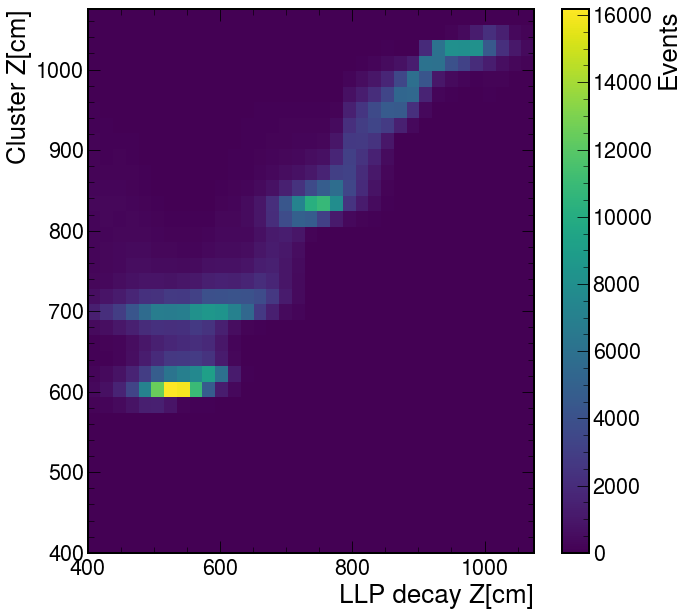

In [58]:
hist.plot2d(hz,xaxis="z_llp")